## DeepDream - 深度理解神经网路结构及应用

`背景`图像起点`多层`网络（全通道）

In [1]:
import time

import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np
import IPython.display as display
import PIL.Image

## 定义相关函数

In [3]:
# 图像标准化
def normalize_iamge(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

In [4]:
# 定义图像可视化函数
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [5]:
# 定义保存图像文件函数
def save_image(img, file_name):
    PIL.Image.fromarray(np.array(img)).save(file_name)

In [6]:
# 定义读取指定图像文件函数，可以设置图像最大尺寸
def read_image(file_name, max_dim=None):
    img = PIL.Image.open(file_name)
    if max_dim:
        img.thumbnail((max_dim, max_dim))

    return np.array(img)

## 读取待处理图像文件

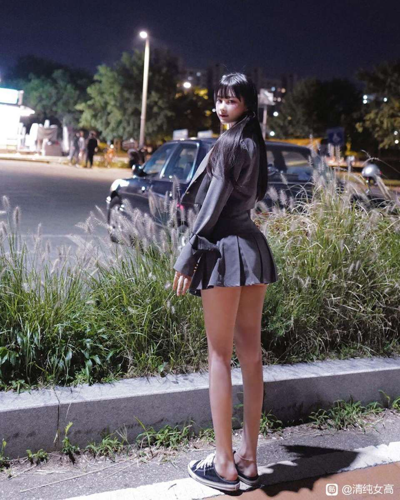

In [7]:
# 读取待处理图像
image_file = "Image/IMG_0722.JPG"

original_image = read_image(image_file,max_dim=500)

show_image(original_image)

## 预训练模型加载

In [8]:
# 去掉顶层，就能接受新的训练数据shape
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")

In [9]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

Inception模型

+ InceptionV3模型架构庞大，有“mixed0”到“mixed10”共11层
+ 使用不同的层会产生不同的图像，较深的层对较高级的特征（如眼睛和脸）有相应，而较早的层对较简单的特征（如边缘、形状和纹理）有相应
+ 可自由尝试选择不同的层，更深的层（具有更高索引的层）需要更长的时间进行训练，因为梯度计算更加深入

## 选择卷积层和通道

### 确定需要最大化激活的卷积层

In [10]:
# 最大限度激活这些层的指定层
layer_name = ["mixed3", "mixed5"]

layers = [base_model.get_layer(name).output for name in layer_name]

In [11]:
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

## 创建特征提取模型

In [12]:
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

## 计算损失（多通道总和）

损失是选中曾的通道输出

In [13]:
def cal_loss(img, model):
    # 对图像做变形，由（300，300，3）扩展为（1，300，300，3）
    # 使用的图像数据格式通常是（height，width，channel），只能表示一张图像
    # 而Inception模型要求的输入格式是（batch，height，width，channel），即同时将多张图像送入网络
    img = tf.expand_dims(img, axis=0)

    # 图像通过模型前向传播得到的计算结果
    layer_activations = model(img)

    # 计算选中每通道的计算结果均值
    losses = []

    for activation in layer_activations:
        loss = tf.math.reduce_mean(activation)
        losses.append(loss)

    # 返回每通道的计算结果和
    return tf.reduce_mean(losses)

## 定义图像优化过程

In [14]:
# 通过梯度上升进行图像调整
def render_deep_dream(model, img, steps=100, step_size=0.01, verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            # 对img进行梯度变换
            tape.watch(img)
            loss = cal_loss(img, model)

        # 计算损失相对于输入图像像素的梯度
        gradients = tape.gradient(loss, img)

        # 归一化梯度值
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # 在梯度上升中，损失值越来越大，因此可以直接添加损失值到图像中，因为他们的shape相同
        img = img + gradients * step_size
        img = tf.clip_by_value(img, -1, 1)

        # 输出过程提示信息
        if (verbose == 1):
            if ((n + 1) % 10 == 0):
                print("Step {}/{}, loss {}".format(n + 1, steps, loss))

    return img

## 数据预处理

In [16]:
img = tf.keras.applications.inception_v3.preprocess_input(original_image)
img = tf.convert_to_tensor(img)

## 执行模型

Start
Step 10/100, loss 0.604526698589325
Step 20/100, loss 0.7476059198379517
Step 30/100, loss 0.834308385848999
Step 40/100, loss 0.8968084454536438
Step 50/100, loss 0.9455196857452393
Step 60/100, loss 0.9870240092277527
Step 70/100, loss 1.0218169689178467
Step 80/100, loss 1.0530486106872559
Step 90/100, loss 1.0815218687057495
Step 100/100, loss 1.1064777374267578
End


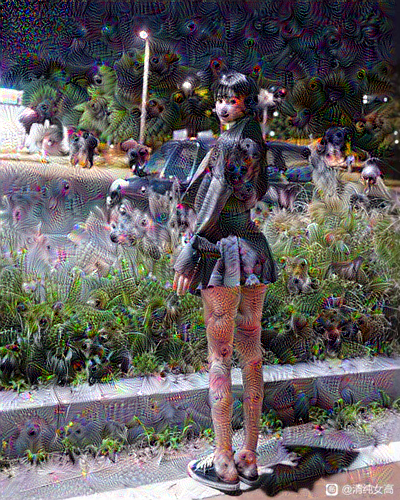

Save as :Image/deep_dream_['mixed3', 'mixed5']_all_with_background.jpg


In [17]:
start = time.time()
print("Start")

# 调用优化过程
dream_img = render_deep_dream(dream_model, img, steps=100, step_size=0.01)

end = time.time()
end - start

print("End")

# 标准化图像
dream_img = normalize_iamge(dream_img)

# 显示图像结果
show_image(dream_img)

# 保存结果图像
file_name = "Image/deep_dream_{}_all_with_background.jpg".format(layer_name)
save_image(dream_img, file_name)
print("Save as :{}".format(file_name))